<a href="https://colab.research.google.com/github/kc1code/EchoNest-Music-Recommender/blob/main/Music_Recommendation_System_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle -q

**Importing the dependencies**

In [2]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


**Data Collection**

In [6]:
kaggle_config = json.load(open('/content/kaggle.json'))

In [7]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [8]:
#set the envirnment varaibles
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [9]:
#loading the dataset using kaggle api
!kaggle datasets download -d notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0


In [10]:
!ls

kaggle.json  sample_data  spotify-million-song-dataset.zip


In [11]:
with zipfile.ZipFile('spotify-million-song-dataset.zip','r') as zip_ref:
  zip_ref.extractall()

In [12]:
#loading the dataset to a pandas dataframe
df = pd.read_csv('/content/spotify_millsongdata.csv')

**Basic Operations on dataset**

In [13]:
df.shape

(57650, 4)

In [14]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [16]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [17]:
#Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [18]:
df = df.sample(1000)
df = df.drop('link', axis=1).reset_index(drop=True)

In [19]:
#wordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)

**WordCloud to visualize the most common words in the lyrics**

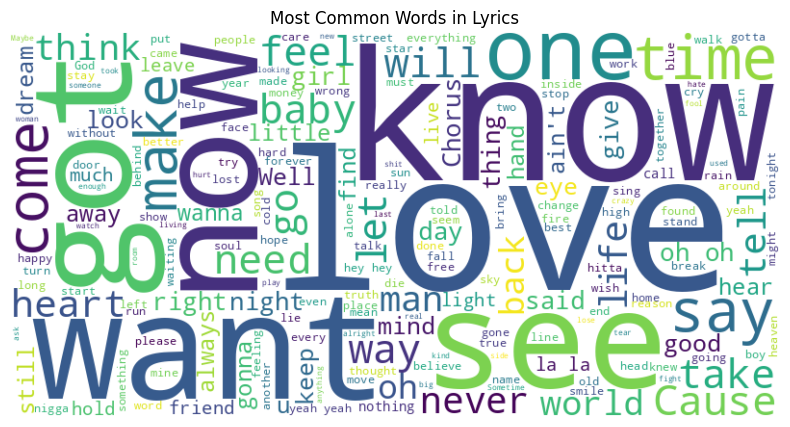

In [20]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Lyrics')
plt.show()

**Data Preprocessing**

In [21]:
#downloading the nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stop_words = set(stopwords.words('english'))

In [25]:
def preprocess_text(text):
  #remove special characters and numbers
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  #convert to lowercase
  text = text.lower()
  #tokenize and remove stopwords
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

In [26]:
#Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [28]:
df.head()

,artist,song,text,cleaned_text
0,Michael W. Smith,A Little Stronger Everyday,I was throwin' away what I needed most \r\nIt...,throwin away needed father son holy ghost litt...
1,Grand Funk Railroad,Time Machine,"Well a-hey there baby, do you want to make the...",well ahey baby want make scene said ahey baby ...
2,Journey,Chain Of Love,One precious moment in a state of grace \r\nS...,one precious moment state grace send mantra en...
3,Cat Stevens,The Laughing Apple,Slowly let me tell you a story of a tree \r\n...,slowly let tell story tree apple tree summerti...
4,Etta James,Tell Mama,You thought you'd found a good girl \r\nOne t...,thought youd found good girl one love give wor...


In [29]:
#Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [30]:
#compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [31]:
#Recommendation function
def recomment_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
  #find the index of the song
  idx = df[df['song'].str.lower() == song_name.lower()].index
  if len(idx) == 0:
    return "Song not found in the dataset"
  idx = idx[0]

  #get similarity scores
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:top_n+1]

  #get song indices
  song_indices = [i[0] for i in sim_scores]

  #Returen top n similar songs
  return df[['artist', 'song']].iloc[song_indices]



In [33]:
df['song'][80]

'Lords Of Summer'

In [34]:
#example
print("\nRecommendations for the song 'Lords Of Summer':")
recommendations = recomment_songs('Lords Of Summer')
print(recommendations)


Recommendations for the song 'Lords Of Summer':
            artist                  song
106  Great Big Sea                Summer
637   Joy Division  Something Must Break
281           Used            Revolution
908   Loretta Lynn   Softly And Tenderly
446     Mary Black      Song For Ireland
